In [1]:
import os
dataset_name = 'DILI'
# filename1 = dataset_name+'_only_sum_tloss.csv'
# if os.path.exists(filename1):
#     os.remove(filename1)
filename2 = dataset_name+'_att_sum_vloss.csv'
# if os.path.exists(filename2):
#     os.remove(filename2)
# filename3 = dataset_name+'_level_auc.csv'
# if os.path.exists(filename3):
#     os.remove(filename3)    

In [2]:
#fast hyperparameter
parameters={
    'l2_coeff':[1e-06],
    'n_epochs':[100],    
    
#     'activation_func':["nn.GELU()","nn.ELU()","nn.ReLU()"],
    'type_conv':[3],
#     'type_conv':[1],    
#     'activation_func':["nn.SiLU()","nn.GELU()","nn.Hardswish()"],    
#     'n_conv':[14,7],      
#     'batch_size':[64,256],        
#     'lr' :[1e-04,5e-05,1e-05,5e-05,1e-06],
    'lr' :[1e-04],    
#     'lr' :[1e-03,5e-04,1e-04,5e-05,1e-05],
#     'lr' :[1e-03],    
#     'n_conv':[10,7,4],
    'n_conv':[4],    
    'seeds':[0],    
    'batch_size':[64],        
    'activation_func':["nn.GELU()"],    
    'Norm':[0], # None,PairNorm,BatchNorm,LayerNorm    
    'skip':[1],    
    
    'hidden_layer':[256],
#     'max_depth':[3,5,10,50],
#     'n_estimators':[500,1000],
#     'lr' :[1e-03,1e-04],    
#     'pooling':['geonn.global_mean_pool','geonn.global_add_pool'],    
#     'lr' :[1e-04],    
#     'pooling':['geonn.global_mean_pool'],    
#     'lr' :[1],        
    'pooling':['geonn.global_add_pool'],   
}

In [3]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_3454985/343306588.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
import torch
GPU_NUM = 1 # 원하는 GPU 번호 입력
torch.set_num_threads(1) 
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  1
NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/home/geonyeongchoi/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/geonyeongchoi/anaconda3/envs/rdkit-env/lib/python3.9/site-packages/torch/cuda/memory.py:384: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [5]:
import numpy
import pandas
import numpy as np
from tqdm import tqdm
from sklearn import preprocessing
from torch_geometric.data import Data
import rdkit
from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Crippen
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import MolSurf
from rdkit.Chem.Descriptors import ExactMolWt
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import torch.nn.functional as F
import torch_geometric.nn as geonn
import torch.nn as nn
import deepchem as dc
import itertools
import ipyparams
from sklearn import metrics

import argparse
import itertools
from func.f_DILI import *


<IPython.core.display.Javascript object>

In [6]:
import numpy
import random
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load dataset
print('Load molecular structures...')
dataset_name = 'DILI'
data = load_dataset_by_name(dataset_name)
mols = data
n_feats=len(mols[0].x[0])
# dataset_name = 'testing'
# test_data = load_dataset_by_name(dataset_name)

Load molecular structures...


100%|██████████████████████████████████████████████| 1204/1204 [00:07<00:00, 158.22it/s]


In [7]:
def FNN_sequential(n_channels,actv):
    fnn_layer = []
    for i in range(2):
        fnn_layer.append(nn.Linear(n_channels, n_channels))
        fnn_layer.append(nn.BatchNorm1d(n_channels))            
        fnn_layer.append(actv)      

    return nn.Sequential(*fnn_layer)

def FNN(in_channels,hid_channels,out_channels,actv):
    fnn_layer = []
    fnn_layer.append(nn.Linear(in_channels, hid_channels))
    fnn_layer.append(nn.BatchNorm1d(hid_channels))            
    fnn_layer.append(actv)      
    
    for i in range(4):
        fnn_layer.append(nn.Linear(hid_channels, hid_channels))
        fnn_layer.append(nn.BatchNorm1d(hid_channels))            
        fnn_layer.append(actv)      
        
    fnn_layer.append(nn.Linear(hid_channels, out_channels))
    
    return nn.Sequential(*fnn_layer)

In [8]:
from torch_geometric.nn.inits import reset


class multihead(nn.Module):
    def __init__(self,t):
        super(multihead, self).__init__()
        self.lin_q = nn.ModuleList()
        self.lin_k = nn.ModuleList()
        self.lin_v = nn.ModuleList()
        
        self.soft = nn.Softmax(dim=1)        
        self.sqrt = math.sqrt(256)
        self.mh = nn.Linear(1024,256)
        
        self.type = t
        
        for _ in range(4):
            self.lin_q.append(nn.Linear(256,256))
            self.lin_k.append(nn.Linear(256,256))
            self.lin_v.append(nn.Linear(256,256))        

                
    def forward(self,q,k,v,b_q,b_kv): 
        
        e3fp = []
        for i in range(4):
            qry = self.lin_q[i](q)         
            key = self.lin_k[i](k)
            val = self.lin_v[i](v)
            
            if(self.type == 'e3fp'):
                att = torch.cat([self.soft(qry[(each_q==b_q).view(-1)]@key[each_q==b_kv.view(-1)].T)@val[each_q==b_kv.view(-1)] for each_q in b_q])                
            else:
                att = torch.cat([self.soft(qry[each_q].view(1,-1)@key[each_q==b_kv.view(-1)].T)@val[each_q==b_kv.view(-1)] for each_q in b_q])            
            
            e3fp.append(att)

#         if(self.type == 'e3fp'):
#             e3fp = [torch.cat([self.soft(self.lin_q[i](q)[(each_q==b_q).view(-1)]@self.lin_k[i](k)[each_q==b_kv.view(-1)].T)@self.lin_v[i](v)[each_q==b_kv.view(-1)] for each_q in b_q]) for i in range(4)]
#         else:
#             e3fp = [torch.cat([self.soft(self.lin_q[i](q)[each_q].view(1,-1)@self.lin_k[i](k)[each_q==b_kv.view(-1)].T)@self.lin_v[i](v)[each_q==b_kv.view(-1)] for each_q in b_q]) for i in range(4)]    
        e3fp = self.mh(torch.cat(e3fp,dim=1))                
        
        return e3fp
        
class MAB(nn.Module):
    def __init__(self):
        super(MAB, self).__init__()
        self.layernorm1 = nn.LayerNorm(256)
        self.layernorm2 = nn.LayerNorm(256)
        self.lin = nn.Linear(256,256)
        self.mh = multihead('else')
        
    def forward(self,q,k,v,b_q,b_kv):        
        h = self.layernorm1(q+self.mh(q,k,v,b_q,b_kv))
        return self.layernorm2(h+self.lin(h))
        
class multihead_last(nn.Module):
    def __init__(self):
        super(multihead_last, self).__init__()
        self.lin_q = nn.ModuleList()
        self.lin_k1 = nn.ModuleList()
        self.lin_k2 = nn.ModuleList()
        self.lin_k3 = nn.ModuleList()
        
        self.lin_v1 = nn.ModuleList()
        self.lin_v2 = nn.ModuleList()
        self.lin_v3 = nn.ModuleList()        
        
        self.soft = nn.Softmax(dim=1)        
        self.sqrt = math.sqrt(256)
        self.mh = nn.Linear(1024,256)
        
        self.layernorm1 = nn.LayerNorm(256)
        self.layernorm2 = nn.LayerNorm(256)
        self.lin = nn.Linear(256,256)        
        
        for _ in range(4):
            self.lin_q.append(nn.Linear(256,256))
            self.lin_k1.append(nn.Linear(256,256))
            self.lin_k2.append(nn.Linear(256,256))
            self.lin_k3.append(nn.Linear(256,256))
            
            self.lin_v1.append(nn.Linear(256,256))        
            self.lin_v2.append(nn.Linear(256,256))        
            self.lin_v3.append(nn.Linear(256,256))                    
                
    def forward(self,q,k1,k2,k3,v1,v2,v3,b_q): 
        
            e3fp = [torch.cat([self.soft(self.lin_q[i](q)[each_q].view(1,-1)@torch.cat((self.lin_k1[i](k1)[each_q].view(1,-1),self.lin_k2[i](k2)[each_q].view(1,-1),self.lin_k3[i](k3)[each_q].view(1,-1)),dim = 0).T)@
                         torch.cat((self.lin_v1[i](v1)[each_q].view(1,-1),self.lin_v2[i](v2)[each_q].view(1,-1),self.lin_v3[i](v3)[each_q].view(1,-1)),dim = 0) for each_q in b_q]) for i in range(4)]
    
            e3fp = self.mh(torch.cat(e3fp,dim=1))        

            h = self.layernorm1(q+e3fp)
            h = self.layernorm2(h+self.lin(h))

            return h

In [9]:
from torch_geometric.nn.inits import reset

class GNN_vanilla(nn.Module):
    def __init__(self,args, num_node_feats):
        super(GNN_vanilla, self).__init__()
        self.input_dim = n_feats
        self.hidden_dim = args.hidden_layer
        self.n_GNN_layer = args.n_conv
        self.m = nn.Sigmoid()
        self.relu = args.activation_func

        self.skip_tf = args.skip
        self.norm_tf = args.Norm
        
        self.input_layer = nn.Linear(2,self.hidden_dim)   
        self.output_layer = nn.Linear(self.hidden_dim,1)
        
        self.pre_layer = FNN_sequential(self.hidden_dim,args.activation_func)
        self.post_layer = FNN_sequential(self.hidden_dim,args.activation_func)
        self.mol_layer = FNN_sequential(self.hidden_dim,args.activation_func)
        
        self.pp_mold2 = FNN_sequential(self.hidden_dim,args.activation_func)
        self.pp_ecfp = FNN_sequential(self.hidden_dim,args.activation_func)
        self.pp_tox21 = FNN_sequential(self.hidden_dim,args.activation_func)
        self.pp_level = FNN_sequential(self.hidden_dim,args.activation_func)
        
        self.mol_dim = nn.Linear(self.hidden_dim+1024+777,self.hidden_dim) 
        self.conv_layers = nn.ModuleList()
        self.norm = nn.ModuleList()
        self.skip_layers = nn.ModuleList()
        
        self.activation = nn.Sigmoid()
        self.model_type = 3
        self.skip_type = 0
        
        self.drops = nn.Dropout(p=0.2)
            
        self.soft = nn.Softmax(dim=1)        
        self.sqrt = math.sqrt(self.hidden_dim)
        self.mol_lin = nn.Linear(self.hidden_dim*3,self.hidden_dim)
        self.mol_FNN = FNN_sequential(self.hidden_dim,args.activation_func)        
        
        self.comb_lin = nn.Linear(self.hidden_dim*4,self.hidden_dim)        
        self.ec_fam = nn.Linear(self.hidden_dim*4,self.hidden_dim)        
        self.seed_vec = torch.nn.Parameter(torch.randn(1,256))
        
        for layer in range(self.n_GNN_layer):
            if(self.model_type==0):
                self.conv_layers.append(geonn.GCNConv(self.hidden_dim,self.hidden_dim))
            elif(self.model_type==1):
                self.conv_layers.append(GNNConv(nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim)),train_eps =False,aggr_type='mean',edge_dim = 3))  
            elif(self.model_type==2):
                self.conv_layers.append(geonn.GATv2Conv(self.hidden_dim,self.hidden_dim,edge_dim = 3,heads=4,concat=False))
            elif(self.model_type==3):
                self.conv_layers.append(GNNConv(nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim)),train_eps =False,edge_dim = 3))  
            if(args.Norm==1):
                self.norm.append(nn.BatchNorm1d(self.hidden_dim))
            if(args.Norm==2):
                self.norm.append(nn.LayerNorm(self.hidden_dim))                
            if(args.Norm==3):
                self.norm.append(geonn.PairNorm())   
                
            if(self.skip_tf ==1):
                self.skip_layers.append(nn.Linear(self.hidden_dim*2,self.hidden_dim))

        self.MAB1 = MAB()        
        self.MAB2 = MAB()        
        self.MAB3 = MAB()        
        self.MAB4 = MAB()        
        self.MAB5 = MAB()        
        
        self.bn = nn.BatchNorm1d(774)
        
    def forward(self, g):

        node_emb = self.input_layer(g.x[:,0:2])
        node_emb = self.pre_layer(node_emb)
        prev_node_emb = node_emb.clone()                
        
        for layer in range(self.n_GNN_layer): #GNN layer
            if(layer%2==0):
                node_emb = self.relu(self.conv_layers[layer](node_emb,g.edge_index,g.edge_attr))+prev_node_emb
                prev_node_emb = node_emb.clone()                
            else:
                node_emb = self.relu(self.conv_layers[layer](node_emb,g.edge_index,g.edge_attr))
            
        node_emb = self.post_layer(node_emb)      
        
        add_emb = geonn.global_add_pool(node_emb,g.batch)   
        
        x_qry = self.seed_vec[[0]*len(g.y)]        
        hg_org = self.MAB1(add_emb,node_emb,node_emb,range(len(g.smiles)),g.batch)   
        hg_org = self.activation(hg_org)
#         hg_pos = self.MAB2(g.derv_pos,node_emb,node_emb,range(len(g.smiles)),g.batch)
#         hg_neg = self.MAB3(g.derv_neg,node_emb,node_emb,range(len(g.smiles)),g.batch)        
        hg_front_pos = self.MAB2(g.actv_pos,node_emb,node_emb,range(len(g.smiles)),g.batch)
        hg_front_neg = self.MAB3(g.actv_neg,node_emb,node_emb,range(len(g.smiles)),g.batch)        
        
        hg = torch.cat([hg_org,hg_front_pos,hg_front_neg],dim=1)
        hg = self.mol_lin(hg)
        hg = self.mol_layer(hg)
        hg = self.output_layer(hg)
        
        return self.m(hg)

In [10]:
def loss_gen(model, optimizer, data_loader, criterion,device):
    model.train()
    train_loss = 0
    
    for i, (batch) in enumerate(data_loader):
        
        batch=batch.to(device)
        pred = model(batch)
        loss = criterion(pred,batch.y)
        optimizer.zero_grad()
        loss.backward()
#         optimizer.step()
        
        train_loss += loss.detach().item()

    return train_loss / len(data_loader)

In [11]:
def loss_gen_pos(model, optimizer, data_loader, criterion,device):
    model.train()
    train_loss = 0
    
    for i, (batch) in enumerate(data_loader):
        
        batch=batch.to(device)
        pred = model(batch)
        loss = criterion(pred,batch.pos_y)
        optimizer.zero_grad()
        loss.backward()
#         optimizer.step()
        
        train_loss += loss.detach().item()

    return train_loss / len(data_loader)

In [12]:
def loss_gen_neg(model, optimizer, data_loader, criterion,device):
    model.train()
    train_loss = 0
    
    for i, (batch) in enumerate(data_loader):
        
        batch=batch.to(device)
        pred = model(batch)
        loss = criterion(pred,batch.neg_y)
        optimizer.zero_grad()
        loss.backward()
#         optimizer.step()
        
        train_loss += loss.detach().item()

    return train_loss / len(data_loader)

In [13]:
def activation_hook_fn(module, input, output):
    activation_values.append(output.detach())
    
def gradient_hook_fn(module, grad_input, grad_output):
    activation_derivatives.append(grad_output[0].detach())    

In [14]:
vvv = pandas.DataFrame()
keys = parameters.keys()
values = (parameters[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]    
for e_num,name in enumerate(combinations):
    print("current comb",e_num,"/",len(combinations))
    paser = argparse.ArgumentParser()
    args = paser.parse_args("")


    for k, v in name.items():
        exec('args.%s = %s' % (k, v))
        exec('%s = %s' % (k, v))  

current comb 0 / 1


In [15]:
cpu_actv = torch.tensor(np.ones((len(mols),256)),dtype=torch.float)
cpu_derv = torch.tensor(np.ones((len(mols),256)),dtype=torch.float)

for idx in range(len(mols)):
    mols[idx]['actv_pos'] = cpu_actv[idx].view(1, -1)
    mols[idx]['derv_pos'] = cpu_derv[idx].view(1, -1)    
    
cpu_actv = torch.tensor(np.zeros((len(mols),256)),dtype=torch.float)
cpu_derv = torch.tensor(np.zeros((len(mols),256)),dtype=torch.float)

for idx in range(len(mols)):
    mols[idx]['actv_neg'] = cpu_actv[idx].view(1, -1)
    mols[idx]['derv_neg'] = cpu_derv[idx].view(1, -1)        
    
for each_mol in mols:
    each_mol['pos_y'] = torch.tensor(1, dtype=torch.float).view(1, 1)
    each_mol['neg_y'] = torch.tensor(0, dtype=torch.float).view(1, 1)        

In [16]:
# model = GNN_vanilla(args,n_feats).to(device) #모델 새로 정의
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coeff)
# criterion = torch.nn.BCELoss()
# forward_hook_handle.remove()
# backward_hook_handle.remove()    
# def activation_hook_fn(module, input, output):
#     activation_values.append(output.detach())


# # Register hooks
# forward_hook_handle = model.activation.register_forward_hook(activation_hook_fn)
# backward_hook_handle = model.activation.register_backward_hook(gradient_hook_fn)
# # forward_hook_handle.remove()
# # backward_hook_handle.remove()

In [17]:
all_loader= DataLoader(mols, batch_size=batch_size, shuffle=False)

In [18]:
mols_y = np.array([int(each_mol['y']) for each_mol in mols])

In [19]:
# activation_values = []
# activation_derivatives = []
# _=loss_gen_pos(model, optimizer, all_loader, criterion,device) 
# cpu_actv = torch.cat(activation_values).cpu()
# cpu_derv = torch.cat(activation_derivatives).cpu()

In [20]:
# activation_values = []
# activation_derivatives = []
# _=loss_gen_pos(model, optimizer, all_loader, criterion,device) 
# cpu_actv = torch.cat(activation_values).cpu()
# cpu_derv = torch.cat(activation_derivatives).cpu()

# for idx in range(len(mols)):
#     mols[idx]['actv_pos'] = cpu_actv[idx].view(1, -1)
#     mols[idx]['derv_pos'] = cpu_derv[idx].view(1, -1)    
    
# activation_values = []
# activation_derivatives = []
# _=loss_gen_neg(model, optimizer, all_loader, criterion,device) 
# cpu_actv = torch.cat(activation_values).cpu()
# cpu_derv = torch.cat(activation_derivatives).cpu()

# for idx in range(len(mols)):
#     mols[idx]['actv_neg'] = cpu_actv[idx].view(1, -1)
#     mols[idx]['derv_neg'] = cpu_derv[idx].view(1, -1)        

In [21]:
# activation_values = []
# activation_derivatives = []
# _=loss_gen(model, optimizer, all_loader, criterion,device) 

In [22]:
# torch.cat(activation_derivatives).cpu().shape

In [23]:
import umap
import matplotlib.pyplot as plt
# reducer = umap.UMAP()
# features = np.array(torch.cat(activation_values).cpu())
# embedding = reducer.fit_transform(features)

# plt.scatter(embedding[:, 0], embedding[:, 1], c=mols_y, cmap='Spectral', s=5)
# plt.colorbar()
# plt.title('UMAP projection of the DILIst dataset')
# plt.show()


In [24]:
# import umap
# import matplotlib.pyplot as plt

# reducer = umap.UMAP()
# features = np.array(torch.cat(activation_derivatives).cpu())
# embedding = reducer.fit_transform(features)

# plt.scatter(embedding[:, 0], embedding[:, 1], c=mols_y, cmap='Spectral', s=5)
# plt.colorbar()
# plt.title('UMAP projection of the DILIst dataset')
# plt.show()


In [25]:
from sklearn.metrics import mean_squared_error
import math
from copy import copy

tr_loss_rec = []
val_loss_rec = []
vt_all_rec = []
train_rec = pandas.DataFrame()
valid_rec = pandas.DataFrame()
test_rec = pandas.DataFrame()
train_rec2 = pandas.DataFrame()
test_rec2 = pandas.DataFrame()
vt_rec = pandas.DataFrame()
train_rec3 = pandas.DataFrame()
valid_rec3 = pandas.DataFrame()
test_rec3 = pandas.DataFrame()

data_test= [i.smiles for i in mols]
dataset = dc.data.DiskDataset.from_numpy(X=np.zeros(len(data_test)),ids=data_test)
mols_y = [int(each_mol['y']) for each_mol in mols]
splitter = dc.splits.ScaffoldSplitter()

vvv = pandas.DataFrame()
keys = parameters.keys()
values = (parameters[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]    

for e_num,name in enumerate(combinations):
    print("current comb",e_num,"/",len(combinations))
    paser = argparse.ArgumentParser()
    args = paser.parse_args("")


    for k, v in name.items():
        exec('args.%s = %s' % (k, v))
        exec('%s = %s' % (k, v))  
        
    ind_mols = np.array(range(len(mols)))
    random.seed(42)
    random.shuffle(ind_mols)
    shuffled_mols = [mols[sn] for sn in ind_mols]

    mols_y = [int(each_mol['y']) for each_mol in shuffled_mols]
    splitter = dc.splits.ScaffoldSplitter()       

    data_test= [i.smiles for i in shuffled_mols]
    dataset = dc.data.DiskDataset.from_numpy(X=np.zeros(len(data_test)),ids=data_test)        

    tr_ind,val_ind,ts_ind = splitter.split(dataset,frac_train=0.8,frac_valid=0.1,frac_test=0.1)  
    vt_ind = copy(val_ind)
    vt_ind.extend(ts_ind)        

    X_tr,y_tr   = [shuffled_mols[i] for i in tr_ind] ,[mols_y[i] for i in tr_ind]
    X_val,y_val = [shuffled_mols[i] for i in val_ind],[mols_y[i] for i in val_ind]
    X_ts,y_ts   = [shuffled_mols[i] for i in ts_ind] ,[mols_y[i] for i in ts_ind]

    X_vt,y_vt = [shuffled_mols[i] for i in vt_ind],[mols_y[i] for i in vt_ind]

    all_loader= DataLoader(mols, batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(X_tr, batch_size=batch_size, shuffle=True)
    train_loader_no_shuffle = DataLoader(X_tr, batch_size=batch_size, shuffle=False)

    valid_loader = DataLoader(X_val, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(X_ts, batch_size=batch_size, shuffle=False)

    vt_loader = DataLoader(X_vt, batch_size=batch_size, shuffle=False)        

    stop_std = 100
    stop_std2 = 100
    stop_std3 = 0
        
    model = GNN_vanilla(args,n_feats).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coeff)
    criterion = torch.nn.BCELoss()
    
    forward_hook_handle = model.activation.register_forward_hook(activation_hook_fn)
    backward_hook_handle = model.activation.register_backward_hook(gradient_hook_fn)
    
    activation_values = []
    activation_derivatives = []
    _=loss_gen_pos(model, optimizer, all_loader, criterion,device) 
    
    cpu_actv = torch.cat(activation_values).cpu()
    cpu_derv = torch.cat(activation_derivatives).cpu()

    for idx in range(len(mols)):
        mols[idx]['actv_pos'] = cpu_actv[idx].view(1, -1)
        mols[idx]['derv_pos'] = cpu_derv[idx].view(1, -1)    

    activation_values = []
    activation_derivatives = []
    _=loss_gen_neg(model, optimizer, all_loader, criterion,device) 
    cpu_actv = torch.cat(activation_values).cpu()
    cpu_derv = torch.cat(activation_derivatives).cpu()    
    
    activation_values = []
    activation_derivatives = []
    _=loss_gen_neg(model, optimizer, all_loader, criterion,device) 
    cpu_actv = torch.cat(activation_values).cpu()
    cpu_derv = torch.cat(activation_derivatives).cpu()

    for idx in range(len(mols)):
        mols[idx]['actv_neg'] = cpu_actv[idx].view(1, -1)
        mols[idx]['derv_neg'] = cpu_derv[idx].view(1, -1)     
    vv = []
        
    for i in tqdm(range(1,n_epochs+1)):
        
        forward_hook_handle.remove()
        backward_hook_handle.remove()
        v_l = cal_loss(model, optimizer, valid_loader, criterion,device)  
        t_l = train(model, optimizer, train_loader, criterion,device)  
        
        forward_hook_handle = model.activation.register_forward_hook(activation_hook_fn)
        backward_hook_handle = model.activation.register_backward_hook(gradient_hook_fn)
        
        activation_values = []
        activation_derivatives = []
        _=loss_gen_pos(model, optimizer, all_loader, criterion,device) 
        cpu_actv = torch.cat(activation_values).cpu()
        cpu_derv = torch.cat(activation_derivatives).cpu()

        for idx in range(len(mols)):
            mols[idx]['actv_pos'] = cpu_actv[idx].view(1, -1)
            mols[idx]['derv_pos'] = cpu_derv[idx].view(1, -1)    

        activation_values = []
        activation_derivatives = []
        _=loss_gen_neg(model, optimizer, all_loader, criterion,device) 
        cpu_actv = torch.cat(activation_values).cpu()
        cpu_derv = torch.cat(activation_derivatives).cpu()

        for idx in range(len(mols)):
            mols[idx]['actv_neg'] = cpu_actv[idx].view(1, -1)
            mols[idx]['derv_neg'] = cpu_derv[idx].view(1, -1)    


        tr_loss_rec.append(t_l)
        val_loss_rec.append(v_l)            

        stop_pred = test(model, valid_loader,device)
        vt_all_rec.append(all_stats(y_val,stop_pred).loc[0][0])

        stop_res = v_l
        stop_res2 = t_l

        if(stop_std > stop_res):
            stop_std = stop_res                
            test_y_pred = test(model, test_loader,device)

        if((i%5)==0):
            bb = pd.DataFrame([e_num,i,str(e_num)+'_'+str(i),n_conv,activation_func,l2_coeff,lr,batch_size,float(all_stats(y_ts,test_y_pred).iloc[:,0])]).T                    
            bb.to_csv(filename2, mode='a', header=False)    

    del(model)
    torch.cuda.empty_cache()

current comb 0 / 1


 90%|███████████████████████████████████████████▏    | 90/100 [1:17:14<08:34, 51.50s/it]


KeyboardInterrupt: 

1 0.711746


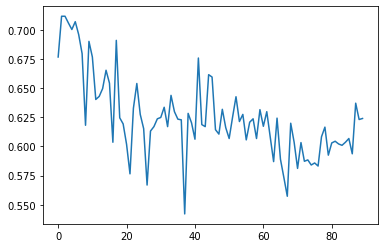

In [26]:
import matplotlib.pyplot as plt
print(vt_all_rec.index(max(vt_all_rec)),round(max(vt_all_rec),6))
plt.plot(vt_all_rec)

In [31]:
round(tr_loss_rec[1],3),round(tr_loss_rec[10],3),round(tr_loss_rec[40],3)

(0.636, 0.457, 0.123)

,0,1,2


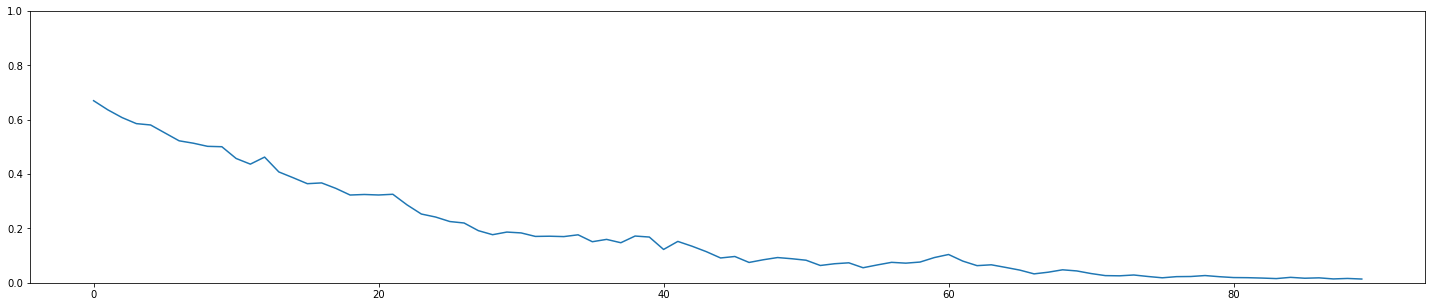

In [27]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,5)
plt.plot(tr_loss_rec)
plt.ylim([0, 1])
pd.concat((train_rec2.mean().T,vt_rec.mean().T,test_rec2.mean().T),axis=1)

,0,1,2


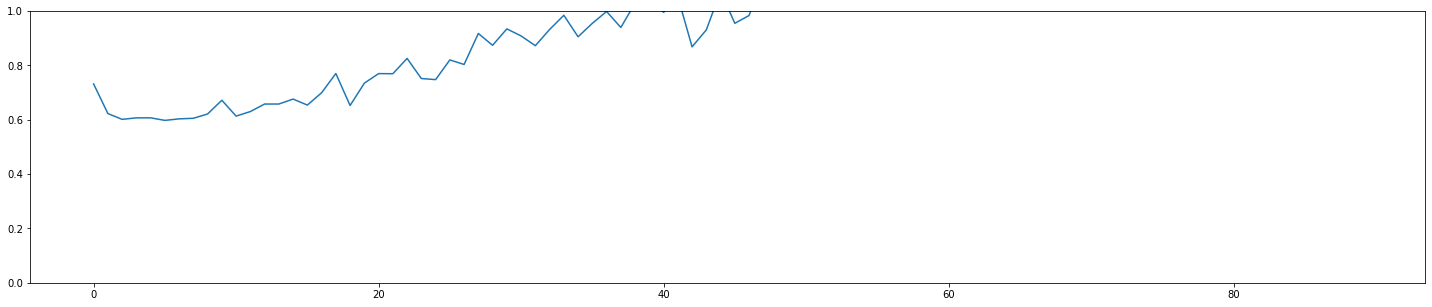

In [28]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,5)
plt.plot(val_loss_rec)
plt.ylim([0, 1])
pd.concat((train_rec.mean().T,valid_rec.mean().T,test_rec.mean().T),axis=1)

,0,1,2


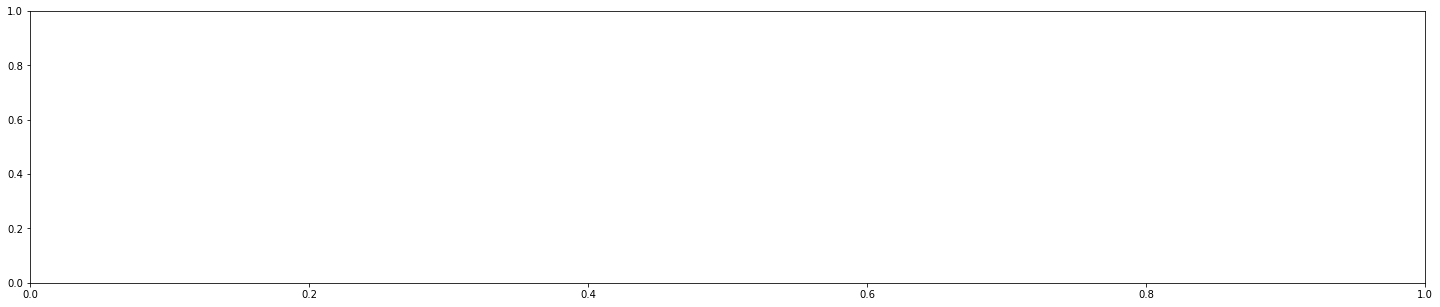

In [29]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,5)
plt.ylim([0, 1])
pd.concat((train_rec3.mean()
           .T,valid_rec3.mean().T,test_rec3.mean().T),axis=1)

In [ ]:
from rdkit import Chem

Chem.MolFromSmiles('CCCCCCCCCCCCC')
